In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
NoTimeSteps = 100
NoAssetSteps = 50
Expiry = 1.0
TimeStep = Expiry / NoTimeSteps

In [3]:
def option_value_3d(vol, int_rate, p_type, strike, expiration, NAS):
    # NAS is number of asset steps
    S = np.zeros(NAS + 1)  # Asset array
    dS = 3 * strike / NAS  # 'Infinity' is twice the strike
    dt = 0.9 / vol ** 2 / NAS ** 2  # For stability
    NTS = int(expiration / dt) + 1  # Number of time steps
    dt = expiration / NTS  # To ensure that expiration is an integer number of time steps away
    V = np.zeros((NAS + 1, NTS + 1))  # Option value array
    q = 1
    if p_type == "put":
        q = -1

    for i in range(NAS + 1):
        #ds is asset step e.g. ticks
        S[i] = i * dS

        # payoff function
        # sets values at time t_0 based on the set up asset prices
        V[i, 0] = max(q * (S[i] - strike), 0)

    for k in range(1, NTS + 1):  # Time loop
        ## And now ta dam ... Nobel prize winning diff equation ;)
        for i in range(1, NAS):  # Asset loop
            delta = (V[i + 1, k - 1] - V[i - 1, k - 1]) / 2 / dS  # Central difference
            gamma = (V[i + 1, k - 1] - 2 * V[i, k - 1] + V[i - 1, k - 1]) / dS / dS  # Central difference
            theta = -0.5 * vol ** 2 * S[i] ** 2 * gamma - int_rate * S[i] * delta + int_rate * V[i, k - 1]  # Black-Scholes
            V[i, k] = V[i, k - 1] - dt * theta

        V[0, k] = V[0, k - 1] * (1 - int_rate * dt)  # Boundary condition at S=0
        V[NAS, k] = 2 * V[NAS - 1, k] - V[NAS - 2, k]  # Boundary condition at S=infinity

    asset_range = np.arange(0, NAS + 1) * dS  # Asset price range
    time_steps = np.arange(0, NTS + 1) * dt
    rounded_time_steps = np.round(time_steps, decimals=3)
    df = pd.DataFrame(V, index=asset_range, columns=rounded_time_steps).round(3)

    return df  # Output array


In [4]:
sigma = 0.2
r = 0.05
K = 100
T = 1
NAS = 20 # number of asset steps

option_df = option_value_3d(sigma, r, "call", K, T, NAS)

In [5]:
option_df.tail()

,0.000,0.056,0.111,0.167,0.222,0.278,0.333,0.389,0.444,0.500,0.556,0.611,0.667,0.722,0.778,0.833,0.889,0.944,1.000
240.0,140.0,140.278,140.555,140.831,141.106,141.381,141.655,141.928,142.201,142.472,142.743,143.013,143.283,143.552,143.819,144.087,144.353,144.619,144.884
255.0,155.0,155.278,155.555,155.831,156.106,156.381,156.655,156.928,157.201,157.472,157.743,158.013,158.283,158.552,158.819,159.087,159.353,159.619,159.884
270.0,170.0,170.278,170.555,170.831,171.106,171.381,171.655,171.928,172.201,172.472,172.743,173.013,173.283,173.552,173.819,174.087,174.353,174.619,174.884
285.0,185.0,185.278,185.555,185.831,186.106,186.381,186.655,186.928,187.201,187.472,187.743,188.013,188.283,188.552,188.819,189.087,189.353,189.619,189.884
300.0,200.0,200.278,200.555,200.831,201.106,201.381,201.655,201.928,202.201,202.472,202.743,203.013,203.283,203.552,203.819,204.087,204.353,204.619,204.884


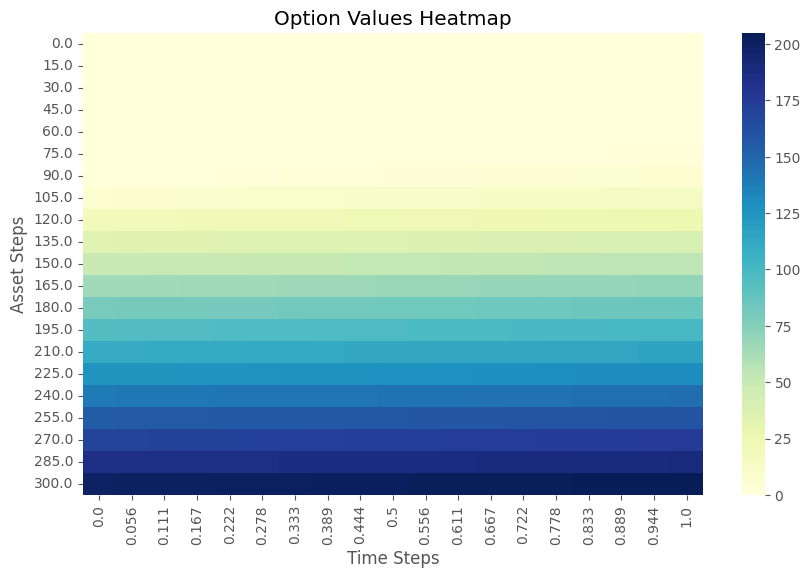

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(option_df, cmap='YlGnBu', fmt=".3f")
plt.title('Option Values Heatmap')
plt.xlabel('Time Steps')
plt.ylabel('Asset Steps')
plt.show()

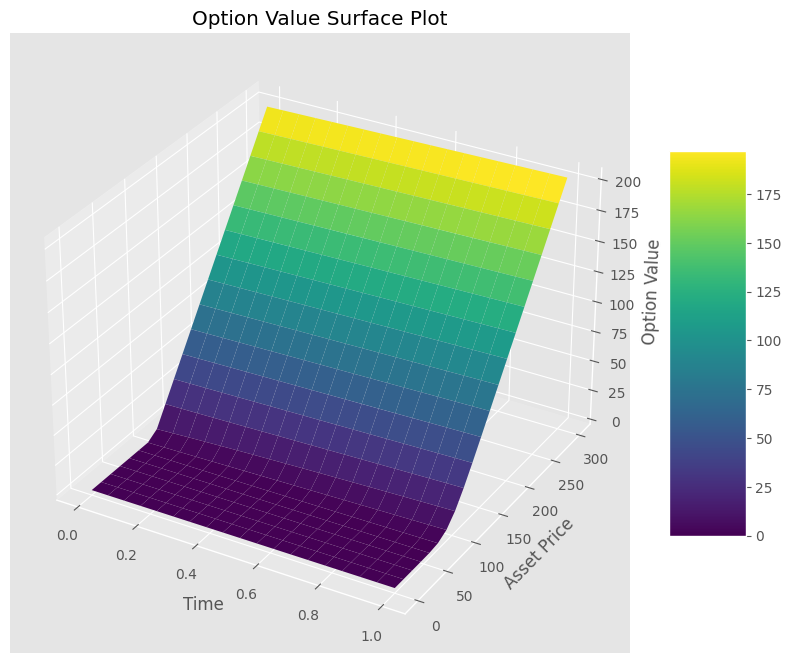

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(option_df.columns, option_df.index)
Z = option_df.values

surf = ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Time')
ax.set_ylabel('Asset Price')
ax.set_zlabel('Option Value')
ax.set_title('Option Value Surface Plot')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

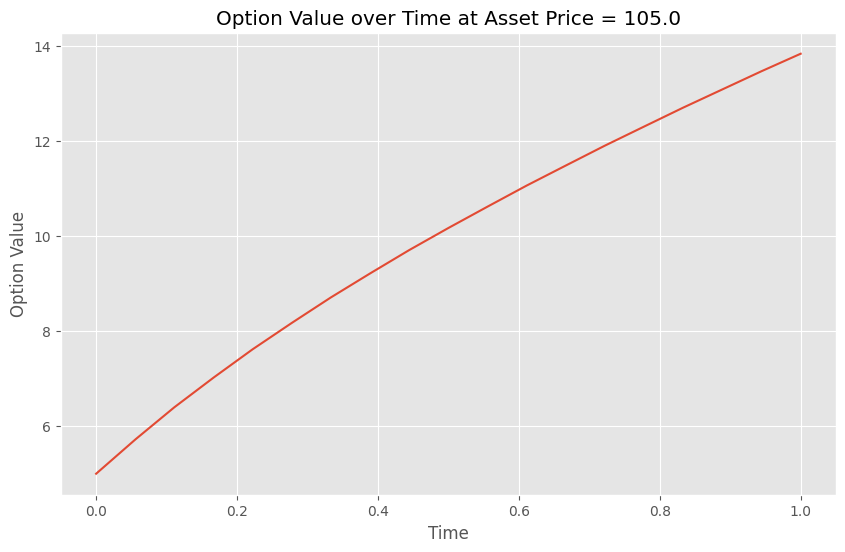

In [9]:
# Choose an asset price to plot (e.g., the strike price)
asset_price_to_plot = K

# Find the closest asset price in the DataFrame index to the strike price
closest_asset_price = option_df.index[option_df.index.get_indexer([asset_price_to_plot], method='nearest')][0]

# Get the row corresponding to the closest asset price
option_value_over_time = option_df.loc[closest_asset_price]

plt.figure(figsize=(10, 6))
plt.plot(option_value_over_time.index, option_value_over_time.values)
plt.xlabel('Time')
plt.ylabel('Option Value')
plt.title(f'Option Value over Time at Asset Price = {closest_asset_price}')
plt.grid(True)
plt.show()

In [13]:
# Increase the number of asset steps to potentially reduce the error
NAS = 50 # increased from 20

# Recalculate the option values with the new NAS
option_df = option_value_3d(sigma, r, "call", K, T, NAS)

# Find the closest asset price in the DataFrame index to the strike price
closest_asset_price = option_df.index[option_df.index.get_indexer([K], method='nearest')][0]

# Get the row corresponding to the closest asset price
option_value_over_time = option_df.loc[closest_asset_price]

# Calculate the difference in option value at the strike price between the last two time steps
error = abs(option_value_over_time.iloc[-1] - option_value_over_time.iloc[-2])

# Calculate the percentage error relative to the last option value
percentage_error = (error / option_value_over_time.iloc[-1]) * 100

print(f"The difference in option value at the strike price between the last two time steps is: {error:.4f}")
print(f"The percentage error is: {percentage_error:.4f}%")

The difference in option value at the strike price between the last two time steps is: 0.0580
The percentage error is: 0.4933%
